# CIFAR vectorized LiRA example

This notebook mirrors A_cifar_main.ipynb but configures the LiRA attack to use the vectorized fast path.

It is safer to delete previous results for target and shadow models as it will train new models. 


In [1]:
import os
import sys
import yaml

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)

train_config_path = "train_robust.yaml"
audit_config_path = "audit_robust.yaml"


In [2]:
from leakpro import LeakPro

RETRAIN_TARGET = False


Next, we create the population dataset by concatenating the train and test data. To create the population, we make use of the UserDataset provided in the InputHandler.

In [3]:
from torchvision.datasets import CIFAR10, CIFAR100
from torch import cat, tensor
import pickle
from cifar_handler import CifarInputHandler

# Load the config.yaml file
with open(train_config_path, 'r') as file:
    train_config = yaml.safe_load(file)
    

In [4]:
data_root = train_config["data"]["data_dir"]
data_path = os.path.join(os.getcwd(), data_root)

if RETRAIN_TARGET:
    # Load the CIFAR train and test datasets
    if train_config["data"]["dataset"] == "cifar10":
        trainset = CIFAR10(root=data_root, train=True, download=True)
        testset = CIFAR10(root=data_root, train=False, download=True)
    elif train_config["data"]["dataset"] == "cifar100":
        trainset = CIFAR100(root=data_root, train=True, download=True)
        testset = CIFAR100(root=data_root, train=False, download=True)
    else:
        raise ValueError("Unknown dataset type")
    
    train_data = tensor(trainset.data).permute(0, 3, 1, 2).float() / 255  # (N, C, H, W)
    test_data = tensor(testset.data).permute(0, 3, 1, 2).float() / 255
    
    # Ensure train and test data looks correct
    assert train_data.shape[0] == 50000, "Train data should have 50000 samples"
    assert test_data.shape[0] == 10000, "Test data should have 10000 samples"
    assert train_data.shape[1] == 3, "Data should have 3 channels"
    assert test_data.shape[1] == 3, "Data should have 3 channels"
    assert train_data.max() <= 1 and train_data.min() >= 0, "Data should be normalized"
    assert test_data.max() <= 1 and test_data.min() >= 0, "Data should be normalized"
    
    # Concatenate train and test data into the population
    data = cat([train_data.clone().detach(), test_data.clone().detach()], dim=0)
    targets = cat([tensor(trainset.targets), tensor(testset.targets)], dim=0)
    # Create UserDataset object
    population_dataset = CifarInputHandler.UserDataset(data, targets)
    
    assert len(population_dataset) == 60000, "Population dataset should have 60000 samples"
    
    # Store the population dataset to be used by LeakPro 
    dataset_name = train_config["data"]["dataset"]
    file_path =  data_root+"/"+ dataset_name + ".pkl"
    if not os.path.exists(file_path):
        with open(file_path, "wb") as file:
            pickle.dump(population_dataset, file)
            print(f"Save data to {file_path}")
            


With the population dataset stored, we next create the train and test set that will go in to training the target model.

In [5]:
if RETRAIN_TARGET:
    from sklearn.model_selection import train_test_split
    from torch.utils.data import DataLoader
    import numpy as np
    
    train_fraction = train_config["data"]["f_train"]
    test_fraction = train_config["data"]["f_test"]
    batch_size = train_config["train"]["batch_size"]
    
    dataset_size = len(population_dataset)
    train_size = int(train_fraction * dataset_size) 
    test_size = int(test_fraction * dataset_size)
    print(f"original train size: {len(train_data)}, test size: {len(test_data)}")
    print(f"selected train size: {train_size}, test size: {test_size}")
    
    randomize_audit = False
    selected_index = np.arange(train_size + test_size)
    if randomize_audit:
        np.random.shuffle(selected_index)
    train_indices = selected_index[:train_size]
    test_indices = selected_index[train_size:(train_size+test_size)]
    
    # Now define the new target train and test sets
    train_subset = CifarInputHandler.UserDataset(data[train_indices], targets[train_indices])
    test_subset = CifarInputHandler.UserDataset(data[test_indices], targets[test_indices], **train_subset.return_params())
    
    train_loader = DataLoader(train_subset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_subset, batch_size = batch_size, shuffle = False)
    
    # Evaluate mean and variance of the train data
    train_mean = train_subset.mean
    train_std = train_subset.std
    print (f"Train mean: {train_mean}, Train std: {train_std}")


### Train target model
With the train and test dataloader in place, we train a ResNet18. 
After training, we call LeakPro to create metadata that will be used during auditing.

In [6]:
target_dir = train_config["run"]["log_dir"]
print("target_dir:", target_dir)


target_dir: ./B/target


In [7]:
if RETRAIN_TARGET:
    from torch import save, optim, nn
    from target_model_class import ResNet18, WideResNet
    
    # Train the model
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        
    if train_config["data"]["dataset"] == "cifar10":
        num_classes = 10
    elif train_config["data"]["dataset"] == "cifar100":
        num_classes = 100
    else:
        raise ValueError("Invalid dataset name")
    
    # Create instance of target model
    #model = ResNet18(num_classes = num_classes)
    model =  WideResNet(depth=28, num_classes=num_classes, widen_factor=2)
    
    # Read out the relevant parameters for training
    lr = train_config["train"]["learning_rate"]
    weight_decay = train_config["train"]["weight_decay"]
    momentum = train_config["train"]["momentum"]
    epochs = train_config["train"]["epochs"]
        
    # Create optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    #optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # train target model
    train_result = CifarInputHandler().train(dataloader=train_loader,
                                model=model,
                                criterion=criterion,
                                optimizer=optimizer,
                                epochs=epochs)


In [8]:
if RETRAIN_TARGET:
    # Evaluate on test set
    test_result = CifarInputHandler().eval(test_loader, model, criterion)
    
    # Store the model and metadata
    model = train_result.model
    model.to("cpu")
    #with open(train_config["run"]["log_dir"]+"/target_model.pkl", "wb") as f:
    with open(target_dir+"/target_model.pkl", "wb") as f:
        save(model.state_dict(), f)
    
    # Create metadata to be used by LeakPro
    meta_data = LeakPro.make_mia_metadata(train_result = train_result,
                                          optimizer = optimizer,
                                          loss_fn = criterion,
                                          dataloader = train_loader,
                                          test_result = test_result,
                                          epochs = epochs,
                                          train_indices = train_indices,
                                          test_indices = test_indices,
                                          dataset_name = dataset_name)
    
    with open(target_dir+"/model_metadata.pkl", "wb") as f:
        pickle.dump(meta_data, f)
    

Plot accuracy and test of training and test.

In [9]:
import matplotlib.pyplot as plt

if RETRAIN_TARGET:
    train_acc = train_result.metrics.extra["accuracy_history"]
    train_loss = train_result.metrics.extra["loss_history"]
    test_acc = test_result.accuracy
    test_loss = test_result.loss
    
    # Plot training and test accuracy
    plt.figure(figsize=(5, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(len(train_loss)-1, test_acc, 'ro', label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    
    # Plot training and test loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(len(train_loss)-1, test_loss, 'ro', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Train shadow models for audit


In [10]:
from leakpro.schemas import LeakProConfig

with open(audit_config_path, "rb") as f:
    audit_configs = yaml.safe_load(f)
    
leakpro_configs = LeakProConfig(**audit_configs)


In [11]:
shadow_dir = audit_configs["audit"]["output_dir"]
print("shadow_dir:", shadow_dir)


shadow_dir: ./B/output


In [12]:
# Instantiate LeakPro with audit configuration
leakpro = LeakPro(CifarInputHandler, audit_config_path)


2025-11-07 15:12:10,234 INFO     Target model blueprint created from WideResNet in ./target_model_class.py.
11/07/2025 15:12:10:INFO:Target model blueprint created from WideResNet in ./target_model_class.py.
2025-11-07 15:12:10,272 INFO     Loaded target model metadata from ./B/target/model_metadata.pkl
11/07/2025 15:12:10:INFO:Loaded target model metadata from ./B/target/model_metadata.pkl
2025-11-07 15:12:10,335 INFO     Loaded target model from ./B/target
11/07/2025 15:12:10:INFO:Loaded target model from ./B/target
2025-11-07 15:12:11,331 INFO     Loaded population dataset from ./data/cifar10.pkl
11/07/2025 15:12:11:INFO:Loaded population dataset from ./data/cifar10.pkl
2025-11-07 15:12:15.975129: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-07 15:12:16.0391

In [13]:
# Run the audit
mia_results = leakpro.run_audit(create_pdf=True)


2025-11-07 15:12:19,305 INFO     Preparing attack: lira
11/07/2025 15:12:19:INFO:Preparing attack: lira
2025-11-07 15:12:19,636 INFO     Number of existing models exceeds or equals the number of models to create
11/07/2025 15:12:19:INFO:Number of existing models exceeds or equals the number of models to create
2025-11-07 15:12:19,638 INFO     Loading shadow model 0
11/07/2025 15:12:19:INFO:Loading shadow model 0
2025-11-07 15:12:20,048 INFO     Loaded model from ./B/output/attack_objects/shadow_model/shadow_model_0.pkl
11/07/2025 15:12:20:INFO:Loaded model from ./B/output/attack_objects/shadow_model/shadow_model_0.pkl
2025-11-07 15:12:20,052 INFO     Loading shadow model 1
11/07/2025 15:12:20:INFO:Loading shadow model 1
2025-11-07 15:12:20,121 INFO     Loaded model from ./B/output/attack_objects/shadow_model/shadow_model_1.pkl
11/07/2025 15:12:20:INFO:Loaded model from ./B/output/attack_objects/shadow_model/shadow_model_1.pkl
2025-11-07 15:12:20,124 INFO     Loading shadow model 2
11/0

<Figure size 640x480 with 0 Axes>

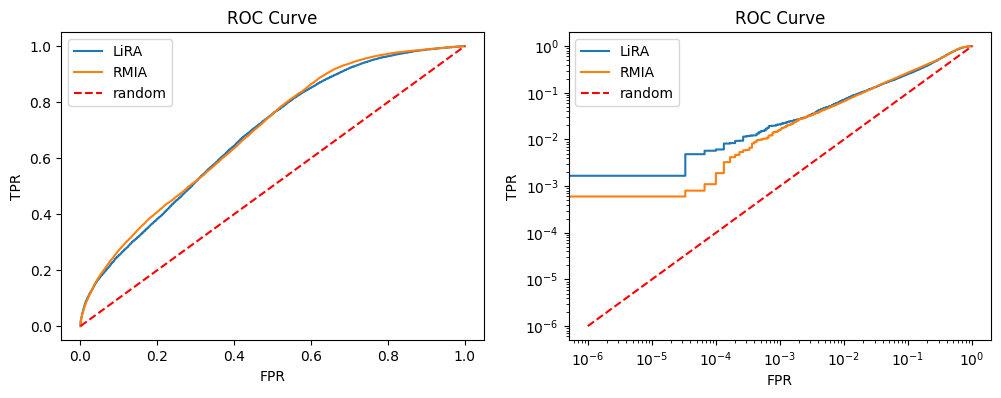

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_results(results, labels=None, smarts=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for ax, flag in zip(axs, [True, False]):
        for i, (fpr, tpr) in enumerate(results):
            label = None if labels is None else labels[i]
            smart = '-' if smarts is None else smarts[i]
            if flag:
                ax.plot(fpr, tpr, smart, label=label)
            else:
                ax.loglog(fpr, tpr, smart, label=label)
        if results:
            diag = np.linspace(1e-6 if not flag else 0.0, 1.0, 200)
            ax.plot(diag, diag, 'r--', label='random')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title('ROC Curve')
        ax.legend()
    plt.show()

mia_roc_curves = []
labels = []
for result in mia_results:
    fpr = getattr(result, 'fpr', None)
    tpr = getattr(result, 'tpr', None)
    if fpr is None or tpr is None:
        continue
    mia_roc_curves.append((fpr, tpr))
    labels.append(result.result_name)

if mia_roc_curves:
    plot_results(mia_roc_curves, labels=labels)
else:
    print('No ROC curves available to plot.')


In [27]:
from leakpro.attacks.mia_attacks.lira import AttackLiRA
from leakpro.attacks.mia_attacks.rmia import AttackRMIA
from leakpro.attacks.mia_attacks.base import AttackBASE

# Find first of each attack type
lira_attack = next((a for a in leakpro.attack_scheduler.attacks if isinstance(a, AttackLiRA)), None)
assert lira_attack is not None, "No attack of type LiRA was found."
rmia_attack = next((a for a in leakpro.attack_scheduler.attacks if isinstance(a, AttackRMIA)), None)
assert rmia_attack is not None, "No attack of type RMIA was found."
#base_attack = next((a for a in leakpro.attack_scheduler.attacks if isinstance(a, AttackBASE)), None)
#assert base_attack is not None, "No attack of type BASE was found."


In [38]:
from leakpro.attacks.utils.shadow_model_handler import ShadowModelHandler

def get_attack_intermediates(attack, verbose=True):
    
    # Get the audit dataset indices and labels from the attack
    audit_data_indices = attack.audit_dataset["data"]
    labels = attack.handler.get_labels(np.arange(len(attack.handler.population)))
    
    # query shadow model handler for intermediate data
    smh = ShadowModelHandler(attack.handler)
    target_logits = smh.load_logits(name="target")
    shadow_inmask = smh.get_in_indices_mask(attack.shadow_model_indices, attack.audit_dataset["data"])
    shadow_logits_list = [smh.load_logits(indx=indx) for indx in attack.shadow_model_indices]

    # Now create in indices mask for target model compliant with those for shadow
    target_inmask = np.zeros_like(audit_data_indices, dtype=bool)
    target_inmask[attack.train_indices] = True

    # Optionally output descriptive data
    if verbose:
        print("target_logits",target_logits.shape)
        print("len(shadow_logits_list)",len(shadow_logits_list))
        print("shadow_logits_list[0]",shadow_logits_list[0].shape)
        print("shadow_inmask",shadow_inmask.shape)
        print("target_inmask",shadow_inmask.shape)
        print("labels",labels.shape)

    return {
        "audit_data_indices": audit_data_indices, 
        "target_logits": target_logits, 
        "target_inmask": target_inmask, 
        "shadow_logits_list": shadow_logits_list, 
        "shadow_inmask": shadow_inmask, 
        "labels": labels
    }

rmia_cache = get_attack_intermediates(rmia_attack)    


2025-11-07 15:53:39,360 INFO     Logits already cached at ./B/output/attack_cache/shadow_model/target_logits.npy
11/07/2025 15:53:39:INFO:Logits already cached at ./B/output/attack_cache/shadow_model/target_logits.npy
2025-11-07 15:53:39,366 INFO     Loaded logits from ./B/output/attack_cache/shadow_model/target_logits.npy
11/07/2025 15:53:39:INFO:Loaded logits from ./B/output/attack_cache/shadow_model/target_logits.npy
2025-11-07 15:53:39,367 INFO     Loading metadata 0
11/07/2025 15:53:39:INFO:Loading metadata 0
2025-11-07 15:53:39,385 INFO     Loading metadata 1
11/07/2025 15:53:39:INFO:Loading metadata 1
2025-11-07 15:53:39,401 INFO     Loading metadata 2
11/07/2025 15:53:39:INFO:Loading metadata 2
2025-11-07 15:53:39,419 INFO     Loading metadata 3
11/07/2025 15:53:39:INFO:Loading metadata 3
2025-11-07 15:53:39,436 INFO     Loading metadata 4
11/07/2025 15:53:39:INFO:Loading metadata 4
2025-11-07 15:53:39,453 INFO     Loading metadata 5
11/07/2025 15:53:39:INFO:Loading metadata 5


target_logits (60000, 10)
len(shadow_logits_list) 20
shadow_logits_list[0] (60000, 10)
shadow_inmask (60000, 20)
target_inmask (60000, 20)
labels (60000,)


In [58]:
from leakpro.attacks.mia_attacks.rmia import rmia_get_gtlprobs

temperature = 1.0

target_gtl_probs = rmia_get_gtlprobs(rmia_cache["target_logits"], rmia_cache["labels"], temperature)
shadow_gtl_probs = np.vstack([
    rmia_get_gtlprobs(logits, rmia_cache["labels"], temperature) for logits in rmia_cache["shadow_logits_list"]
]).T

print("target_gtl_probs",target_gtl_probs.shape)
print("shadow_gtl_probs",shadow_gtl_probs.shape)


target_gtl_probs (60000,)
shadow_gtl_probs (60000, 20)


In [59]:
filepath = target_dir + "/intermediates/rmia"
os.makedirs(filepath, exist_ok=True)

print("store target results in ", filepath)

np.save(filepath + "/gtl_probabilities.npy", target_gtl_probs[:,None]) # make it 2D array
np.save(filepath + "/in_indices_masks.npy", rmia_cache["target_inmask"][:,None]) #  make it 2D array
np.save(filepath + "/audit_data_indices.npy", rmia_cache["audit_data_indices"])


store target results in  ./B/target/intermediates/rmia


In [60]:
filepath = shadow_dir + "/intermediates/rmia"
os.makedirs(filepath, exist_ok=True)

print("store shadow results in ", filepath)

np.save(filepath + "/gtl_probabilities.npy", shadow_gtl_probs)
np.save(filepath + "/in_indices_masks.npy", rmia_cache["shadow_inmask"])
np.save(filepath + "/audit_data_indices.npy", rmia_cache["audit_data_indices"])


store shadow results in  ./B/output/intermediates/rmia


In [48]:
lira_cache = get_attack_intermediates(lira_attack)    


2025-11-07 16:00:22,486 INFO     Logits already cached at ./B/output/attack_cache/shadow_model/target_logits.npy
11/07/2025 16:00:22:INFO:Logits already cached at ./B/output/attack_cache/shadow_model/target_logits.npy
2025-11-07 16:00:22,492 INFO     Loaded logits from ./B/output/attack_cache/shadow_model/target_logits.npy
11/07/2025 16:00:22:INFO:Loaded logits from ./B/output/attack_cache/shadow_model/target_logits.npy
2025-11-07 16:00:22,494 INFO     Loading metadata 0
11/07/2025 16:00:22:INFO:Loading metadata 0
2025-11-07 16:00:22,512 INFO     Loading metadata 1
11/07/2025 16:00:22:INFO:Loading metadata 1
2025-11-07 16:00:22,531 INFO     Loading metadata 2
11/07/2025 16:00:22:INFO:Loading metadata 2
2025-11-07 16:00:22,549 INFO     Loading metadata 3
11/07/2025 16:00:22:INFO:Loading metadata 3
2025-11-07 16:00:22,568 INFO     Loading metadata 4
11/07/2025 16:00:22:INFO:Loading metadata 4
2025-11-07 16:00:22,585 INFO     Loading metadata 5
11/07/2025 16:00:22:INFO:Loading metadata 5


target_logits (60000, 10)
len(shadow_logits_list) 20
shadow_logits_list[0] (60000, 10)
shadow_inmask (60000, 20)
target_inmask (60000, 20)
labels (60000,)


In [51]:
target_rs_logits = lira_attack.rescale_logits(lira_cache["target_logits"], lira_cache["labels"])
shadow_rs_logits = np.vstack([
    lira_attack.rescale_logits(logits, lira_cache["labels"]) for logits in lira_cache["shadow_logits_list"]
]).T

print("target_rs_logits",target_rs_logits.shape)
print("shadow_rs_logits",shadow_rs_logits.shape)


target_rs_logits (60000,)
shadow_rs_logits (60000, 20)


In [56]:
filepath = target_dir + "/intermediates/lira"
os.makedirs(filepath, exist_ok=True)

print("store target results in ", filepath)

np.save(filepath + "/rescaled_logits.npy", target_rs_logits[:,None]) # make it 2D array
np.save(filepath + "/in_indices_masks.npy", lira_cache["target_inmask"][:,None]) #  make it 2D array
np.save(filepath + "/audit_data_indices.npy", lira_cache["audit_data_indices"])


store target results in  ./B/target/intermediates/lira


In [57]:
filepath = shadow_dir + "/intermediates/lira"
os.makedirs(filepath, exist_ok=True)

print("store shadow results in ", filepath)

np.save(filepath + "/rescaled_logits.npy", shadow_rs_logits)
np.save(filepath + "/in_indices_masks.npy", lira_cache["shadow_inmask"])
np.save(filepath + "/audit_data_indices.npy", lira_cache["audit_data_indices"])


store shadow results in  ./B/output/intermediates/lira
